In [38]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fiona
import pyproj
import shapely.geometry as geom

Import the `nyc_all_gyms.csv` data we obtained by google maps API.

In [40]:
df_gyms = pd.read_csv('datasets/all_nyc_gyms.csv')
df_gyms

,formatted_address,geometry.location.lat,geometry.location.lng,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,icon,id,name,...,plus_code.compound_code,plus_code.global_code,price_level,rating,reference,types,user_ratings_total,state,zipcode,borough
0,"298 W 231st St, The Bronx, NY 10463, United St...",40.880539,-73.908334,40.881771,-73.907093,40.879072,-73.909793,https://maps.gstatic.com/mapfiles/place_api/ic...,a3485e7994aa8626891015b990080e6dc9d7b6b3,24 Hour Fitness,...,"V3JR+6M The Bronx, New York",87G8V3JR+6M,NaN,3.4,ChIJEfg3t5XzwokRtR2xHxFYi0Q,"['gym', 'health', 'point_of_interest', 'establ...",187.0,NY,10463,Bronx
1,"5520 Broadway, The Bronx, NY 10463, United States",40.877351,-73.905654,40.878701,-73.904305,40.876001,-73.907004,https://maps.gstatic.com/mapfiles/place_api/ic...,81389fd5d6b5dd805551b9beb642637143f06a5c,Blink Fitness,...,"V3GV+WP The Bronx, New York",87G8V3GV+WP,NaN,3.8,ChIJKftkWJHzwokRWTI8LcCn9LI,"['gym', 'health', 'point_of_interest', 'establ...",211.0,NY,10463,Bronx
2,"5500 Broadway, The Bronx, NY 10463, United States",40.876568,-73.906144,40.877848,-73.904852,40.875149,-73.907552,https://maps.gstatic.com/mapfiles/place_api/ic...,93a5f9fa33efd28fa5726eedeaae0a52803eb091,Astral Fitness,...,"V3GV+JG The Bronx, New York",87G8V3GV+JG,NaN,4.2,ChIJqczPWpHzwokR3qB2P5FDkIU,"['gym', 'health', 'point_of_interest', 'establ...",31.0,NY,10463,Bronx
3,"82 W 225th St, The Bronx, NY 10463, United States",40.874076,-73.909262,40.875480,-73.907841,40.872780,-73.910541,https://maps.gstatic.com/mapfiles/place_api/ic...,912d8b13c868012e545577eeaa8be0762506adfb,Planet Fitness,...,"V3FR+J7 The Bronx, New York",87G8V3FR+J7,NaN,4.2,ChIJr3JBXpLzwokR_dIaA6b0vd8,"['gym', 'spa', 'health', 'point_of_interest', ...",309.0,NY,10463,Bronx
4,"453 W 238th St, The Bronx, NY 10463, United St...",40.887410,-73.905057,40.888704,-73.903729,40.886005,-73.906429,https://maps.gstatic.com/mapfiles/place_api/ic...,a272c6a36fa158e12f45a31e7a2bc01896e26c8c,CrossFit La Caja,...,"V3PV+XX The Bronx, New York",87G8V3PV+XX,NaN,4.9,ChIJIUCs9LvzwokRLW1jjLy1ILQ,"['gym', 'health', 'point_of_interest', 'establ...",14.0,NY,10463,Bronx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,"385 Wild Ave, Staten Island, NY 10314, United ...",40.586235,-74.194648,40.587605,-74.193419,40.584905,-74.196118,https://maps.gstatic.com/mapfiles/place_api/ic...,c7127aa3afe2ca6831d948f3a33c9646fdf7d198,No Limitz Gymnastics and Cheerleading Center,...,HRP4+F4 New York,87G7HRP4+F4,NaN,4.4,ChIJncMQ419LwokRUFvqIcE7qVM,"['gym', 'health', 'point_of_interest', 'establ...",22.0,NY,10314,Staten_Island
1810,"1515 Richmond Ave, Staten Island, NY 10314, Un...",40.610805,-74.159848,40.612149,-74.158477,40.609449,-74.161177,https://maps.gstatic.com/mapfiles/place_api/ic...,3847e474ffd69080ef8fefb22aab119055f6ab74,Caddell dry dock,...,JR6R+83 New York,87G7JR6R+83,NaN,0.0,ChIJKeETt1pMwokR8n4kRFXJMes,"['gym', 'health', 'point_of_interest', 'establ...",0.0,NY,10314,Staten_Island
1811,"Commerce St, Staten Island, NY 10314, United S...",40.611892,-74.168454,40.613244,-74.167097,40.610544,-74.169796,https://maps.gstatic.com/mapfiles/place_api/ic...,2636ec1317fcdc6e6885e7c7f22ff40d32573c3f,Aeeee,...,JR6J+QJ New York,87G7JR6J+QJ,NaN,0.0,ChIJu7xtNlhMwokRiUrABb1gNSU,"['gym', 'health', 'point_of_interest', 'establ...",0.0,NY,10314,Staten_Island
1812,"Staten Island, NY 10314, United States",40.604036,-74.148965,40.605591,-74.147614,40.602891,-74.150314,https://maps.gstatic.com/mapfiles/place_api/ic...,13d703d00bcb59b837aade4e76d55d12da9512a0,College of Staten Island Sports and Recreation...,...,JV32+JC New York,87G7JV32+JC,NaN,4.6,ChIJ4cvV9u1NwokRGNvXDSeIOWY,"['gym', 'health', 'point_of_interest', 'establ...",14.0,NY,10314,Staten_Island


Convert the gym's lat, long locations as points and into a geopandas dataframe.

In [41]:
# convert lat, long as points
geometry = [geom.Point(xy) for xy in zip(df_gyms['geometry.location.lng'], 
                                        df_gyms['geometry.location.lat'])]
# drop lat, lng from csv.
df_gyms = df_gyms.drop(['geometry.location.lng', 
                        'geometry.location.lat'], axis=1)

# convert df and points into a geopandas df with espg:4326 
crs = {'init': 'epsg:4326'}
gdf_gyms = gpd.GeoDataFrame(df_gyms, crs=crs, geometry=geometry)

In [42]:
gdf_gyms.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1814 entries, 0 to 1813
Data columns (total 22 columns):
formatted_address                  1814 non-null object
geometry.viewport.northeast.lat    1814 non-null float64
geometry.viewport.northeast.lng    1814 non-null float64
geometry.viewport.southwest.lat    1814 non-null float64
geometry.viewport.southwest.lng    1814 non-null float64
icon                               1814 non-null object
id                                 1814 non-null object
name                               1814 non-null object
opening_hours.open_now             1442 non-null object
photos                             1447 non-null object
place_id                           1814 non-null object
plus_code.compound_code            1810 non-null object
plus_code.global_code              1810 non-null object
price_level                        30 non-null float64
rating                             1806 non-null float64
reference                          1814 n

In [43]:
gdf_gyms['geometry']

0       POINT (-73.90833 40.88054)
1       POINT (-73.90565 40.87735)
2       POINT (-73.90614 40.87657)
3       POINT (-73.90926 40.87408)
4       POINT (-73.90506 40.88741)
                   ...            
1809    POINT (-74.19465 40.58623)
1810    POINT (-74.15985 40.61080)
1811    POINT (-74.16845 40.61189)
1812    POINT (-74.14896 40.60404)
1813    POINT (-74.12319 40.63398)
Name: geometry, Length: 1814, dtype: geometry

Now let's export this a geoJSON

In [13]:
gdf_gyms.to_file("nyc_gyms.geojson", driver='GeoJSON')


### Let's also try to create an aggregate version by CD
We will count the number of gyms by CD and bring in the population and obesity rate for each CD.

In [44]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import fiona
import pyproj
import shapely.geometry as geom

In [46]:
# import CD shape file.
# project geometries to EPSG 4326 to match the projection of the obesity map
df_cd = gpd.read_file('datasets/Population_Obesity_CD.geojson').to_crs(fiona.crs.from_epsg(4326))
df_cd

,boro_cd,shape_area,shape_leng,GEO_ID,GEO_LABEL,GEO_DISPLAY_NAME,total_population_cd,obesity_cd,geometry
0,101.0,4.268659e+07,73762.393219,101.0,Manhattan CD 001,Financial District,130217.345712,24,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ..."
1,102.0,3.768921e+07,34130.595861,102.0,Manhattan CD 002,Greenwich Village and Soho,101000.735022,26,"POLYGON ((-73.99684 40.73736, -73.99362 40.736..."
2,103.0,4.687970e+07,30468.340600,103.0,Manhattan CD 003,Lower East Side and Chinatown,103831.154791,32,"POLYGON ((-73.98878 40.73397, -73.98718 40.733..."
3,104.0,4.931179e+07,67623.946684,104.0,Manhattan CD 004,Clinton and Chelsea,126139.483095,24,"POLYGON ((-73.99394 40.77318, -73.99370 40.773..."
4,105.0,4.379030e+07,35288.305200,105.0,Manhattan CD 005,Midtown,193083.299602,21,"POLYGON ((-73.97301 40.76428, -73.97141 40.763..."
5,106.0,3.872909e+07,42705.937484,106.0,Manhattan CD 006,Stuyvesant Town and Turtle Bay,193731.204933,15,"MULTIPOLYGON (((-73.96128 40.73016, -73.96128 ..."
6,107.0,5.315282e+07,39863.701384,107.0,Manhattan CD 007,Upper West Side,103174.978364,28,"POLYGON ((-73.95965 40.80116, -73.95848 40.800..."
7,108.0,5.516880e+07,53561.096900,108.0,Manhattan CD 008,Upper East Side,164500.003324,28,"MULTIPOLYGON (((-73.94180 40.76905, -73.94257 ..."
8,109.0,4.189218e+07,34959.184938,109.0,Manhattan CD 009,Morningside Heights and Hamilton Heights,166931.655361,26,"POLYGON ((-73.94014 40.83037, -73.93963 40.830..."
9,110.0,3.908463e+07,35825.290700,110.0,Manhattan CD 010,Central Harlem,88571.946738,41,"POLYGON ((-73.93445 40.83598, -73.93456 40.835..."


In [47]:
df_gyms = gpd.read_file('datasets/nyc_gyms.geojson').to_crs(fiona.crs.from_epsg(4326))
df_gyms

,formatted_address,geometry.viewport.northeast.lat,geometry.viewport.northeast.lng,geometry.viewport.southwest.lat,geometry.viewport.southwest.lng,icon,id,name,opening_hours.open_now,photos,...,plus_code.compound_code,plus_code.global_code,price_level,rating,reference,user_ratings_total,state,zipcode,borough,geometry
0,"298 W 231st St, The Bronx, NY 10463, United St...",40.881771,-73.907093,40.879072,-73.909793,https://maps.gstatic.com/mapfiles/place_api/ic...,a3485e7994aa8626891015b990080e6dc9d7b6b3,24 Hour Fitness,1,"[ { ""height"": 3264, ""html_attributions"": [ ""<a...",...,"V3JR+6M The Bronx, New York",87G8V3JR+6M,NaN,3.4,ChIJEfg3t5XzwokRtR2xHxFYi0Q,187.0,NY,10463,Bronx,POINT (-73.90833 40.88054)
1,"5520 Broadway, The Bronx, NY 10463, United States",40.878701,-73.904305,40.876001,-73.907004,https://maps.gstatic.com/mapfiles/place_api/ic...,81389fd5d6b5dd805551b9beb642637143f06a5c,Blink Fitness,1,"[ { ""height"": 4160, ""html_attributions"": [ ""<a...",...,"V3GV+WP The Bronx, New York",87G8V3GV+WP,NaN,3.8,ChIJKftkWJHzwokRWTI8LcCn9LI,211.0,NY,10463,Bronx,POINT (-73.90565 40.87735)
2,"5500 Broadway, The Bronx, NY 10463, United States",40.877848,-73.904852,40.875149,-73.907552,https://maps.gstatic.com/mapfiles/place_api/ic...,93a5f9fa33efd28fa5726eedeaae0a52803eb091,Astral Fitness,1,"[ { ""height"": 864, ""html_attributions"": [ ""<a ...",...,"V3GV+JG The Bronx, New York",87G8V3GV+JG,NaN,4.2,ChIJqczPWpHzwokR3qB2P5FDkIU,31.0,NY,10463,Bronx,POINT (-73.90614 40.87657)
3,"82 W 225th St, The Bronx, NY 10463, United States",40.875480,-73.907841,40.872780,-73.910541,https://maps.gstatic.com/mapfiles/place_api/ic...,912d8b13c868012e545577eeaa8be0762506adfb,Planet Fitness,1,"[ { ""height"": 4032, ""html_attributions"": [ ""<a...",...,"V3FR+J7 The Bronx, New York",87G8V3FR+J7,NaN,4.2,ChIJr3JBXpLzwokR_dIaA6b0vd8,309.0,NY,10463,Bronx,POINT (-73.90926 40.87408)
4,"453 W 238th St, The Bronx, NY 10463, United St...",40.888704,-73.903729,40.886005,-73.906429,https://maps.gstatic.com/mapfiles/place_api/ic...,a272c6a36fa158e12f45a31e7a2bc01896e26c8c,CrossFit La Caja,1,"[ { ""height"": 1334, ""html_attributions"": [ ""<a...",...,"V3PV+XX The Bronx, New York",87G8V3PV+XX,NaN,4.9,ChIJIUCs9LvzwokRLW1jjLy1ILQ,14.0,NY,10463,Bronx,POINT (-73.90506 40.88741)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1809,"385 Wild Ave, Staten Island, NY 10314, United ...",40.587605,-74.193419,40.584905,-74.196118,https://maps.gstatic.com/mapfiles/place_api/ic...,c7127aa3afe2ca6831d948f3a33c9646fdf7d198,No Limitz Gymnastics and Cheerleading Center,1,"[ { ""height"": 4032, ""html_attributions"": [ ""<a...",...,HRP4+F4 New York,87G7HRP4+F4,NaN,4.4,ChIJncMQ419LwokRUFvqIcE7qVM,22.0,NY,10314,Staten_Island,POINT (-74.19465 40.58623)
1810,"1515 Richmond Ave, Staten Island, NY 10314, Un...",40.612149,-74.158477,40.609449,-74.161177,https://maps.gstatic.com/mapfiles/place_api/ic...,3847e474ffd69080ef8fefb22aab119055f6ab74,Caddell dry dock,None,"[ { ""height"": 1836, ""html_attributions"": [ ""<a...",...,JR6R+83 New York,87G7JR6R+83,NaN,0.0,ChIJKeETt1pMwokR8n4kRFXJMes,0.0,NY,10314,Staten_Island,POINT (-74.15985 40.61080)
1811,"Commerce St, Staten Island, NY 10314, United S...",40.613244,-74.167097,40.610544,-74.169796,https://maps.gstatic.com/mapfiles/place_api/ic...,2636ec1317fcdc6e6885e7c7f22ff40d32573c3f,Aeeee,None,None,...,JR6J+QJ New York,87G7JR6J+QJ,NaN,0.0,ChIJu7xtNlhMwokRiUrABb1gNSU,0.0,NY,10314,Staten_Island,POINT (-74.16845 40.61189)
1812,"Staten Island, NY 10314, United States",40.605591,-74.147614,40.602891,-74.150314,https://maps.gstatic.com/mapfiles/place_api/ic...,13d703d00bcb59b837aade4e76d55d12da9512a0,College of Staten Island Sports and Recreation...,None,"[ { ""height"": 4032, ""html_attributions"": [ ""<a...",...,JV32+JC New York,87G7JV32+JC,NaN,4.6,ChIJ4cvV9u1NwokRGNvXDSeIOWY,14.0,NY,10314,Staten_Island,POINT (-74.14896 40.60404)


Spatial join gym locations to CD polygons

In [48]:
df_sjoin = gpd.sjoin(df_cd, df_gyms, how='inner', op='intersects')
df_sjoin

,boro_cd,shape_area,shape_leng,GEO_ID,GEO_LABEL,GEO_DISPLAY_NAME,total_population_cd,obesity_cd,geometry,index_right,...,place_id,plus_code.compound_code,plus_code.global_code,price_level,rating,reference,user_ratings_total,state,zipcode,borough
0,101.0,4.268659e+07,73762.393219,101.0,Manhattan CD 001,Financial District,130217.345712,24,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",976,...,ChIJ5dVBd_NZwokRKGxIdrBYF8M,PXCR+P6 New York,87G7PXCR+P6,NaN,0.0,ChIJ5dVBd_NZwokRKGxIdrBYF8M,0.0,NY,10013,Manhattan
0,101.0,4.268659e+07,73762.393219,101.0,Manhattan CD 001,Financial District,130217.345712,24,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",963,...,ChIJfelmOPRZwokR2S1WtOzQ0xo,PXFQ+2F New York,87G7PXFQ+2F,NaN,5.0,ChIJfelmOPRZwokR2S1WtOzQ0xo,4.0,NY,10013,Manhattan
0,101.0,4.268659e+07,73762.393219,101.0,Manhattan CD 001,Financial District,130217.345712,24,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",985,...,ChIJBV0wN_RZwokR-xW_17Q_eSw,PXFQ+4P New York,87G7PXFQ+4P,NaN,4.6,ChIJBV0wN_RZwokR-xW_17Q_eSw,9.0,NY,10013,Manhattan
0,101.0,4.268659e+07,73762.393219,101.0,Manhattan CD 001,Financial District,130217.345712,24,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",1278,...,ChIJ_Wl47RZawokRqsF3fc00W4s,PX4Q+8W New York,87G7PX4Q+8W,NaN,0.0,ChIJ_Wl47RZawokRqsF3fc00W4s,0.0,NY,10005,Manhattan
0,101.0,4.268659e+07,73762.393219,101.0,Manhattan CD 001,Financial District,130217.345712,24,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",673,...,ChIJ0dTYZxFawokR6Q80CB6XV-w,PX4P+8J New York,87G7PX4P+8J,NaN,3.8,ChIJ0dTYZxFawokR6Q80CB6XV-w,277.0,NY,10004,Manhattan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,503.0,5.990621e+08,189000.708091,503.0,Richmond CD 003,Tottenville and Great Kills,164994.644753,26,"MULTIPOLYGON (((-74.13320 40.53631, -74.13301 ...",1756,...,ChIJtXfle-hLwokR98fkEWI_uQk,"HV67+CG Staten Island, New York",87G7HV67+CG,NaN,4.3,ChIJtXfle-hLwokR98fkEWI_uQk,3.0,NY,10306,Staten_Island
58,503.0,5.990621e+08,189000.708091,503.0,Richmond CD 003,Tottenville and Great Kills,164994.644753,26,"MULTIPOLYGON (((-74.13320 40.53631, -74.13301 ...",1754,...,ChIJvWA11udLwokRfCs9dzo2hAU,"HV67+GJ Staten Island, New York",87G7HV67+GJ,NaN,4.5,ChIJvWA11udLwokRfCs9dzo2hAU,76.0,NY,10306,Staten_Island
58,503.0,5.990621e+08,189000.708091,503.0,Richmond CD 003,Tottenville and Great Kills,164994.644753,26,"MULTIPOLYGON (((-74.13320 40.53631, -74.13301 ...",1781,...,ChIJm7CGyhVLwokRUBIYk8BmDjc,"HR75+58 Staten Island, New York",87G7HR75+58,NaN,0.0,ChIJm7CGyhVLwokRUBIYk8BmDjc,0.0,NY,10312,Staten_Island
58,503.0,5.990621e+08,189000.708091,503.0,Richmond CD 003,Tottenville and Great Kills,164994.644753,26,"MULTIPOLYGON (((-74.13320 40.53631, -74.13301 ...",1778,...,ChIJE5ljTm1LwokR7pgJ9wh9WOI,"HR88+8H Staten Island, New York",87G7HR88+8H,NaN,3.7,ChIJE5ljTm1LwokR7pgJ9wh9WOI,10.0,NY,10312,Staten_Island


Looks like 1806/1814 of the gyms were in the community districts


In [49]:
# see how many boro_cds had gyms
df_sjoin['boro_cd'].nunique()

59

Looks like all the 59 the CDs had gyms inside them

In [50]:
# count number of gyms by community district 
cd_counts = df_sjoin.pivot_table(index=['boro_cd'], 
                                 aggfunc={'place_id':'nunique'}).reset_index().sort_values('place_id',
                                                                                          ascending=False)
cd_counts

,boro_cd,place_id
4,105.0,165
7,108.0,101
6,107.0,94
1,102.0,77
0,101.0,73
29,306.0,70
42,401.0,69
24,301.0,63
25,302.0,61
5,106.0,57


In [51]:
cd_counts['place_id'].describe()

count     59.000000
mean      30.610169
std       29.557668
min        2.000000
25%       10.000000
50%       21.000000
75%       38.000000
max      165.000000
Name: place_id, dtype: float64

In [60]:
# merge back to the origin cd geometries
df_gym_cd = df_cd.merge(cd_counts, how='left',
                        on='boro_cd').rename(columns={'place_id':'number_of_gyms'})
df_gym_cd

,boro_cd,shape_area,shape_leng,GEO_ID,GEO_LABEL,GEO_DISPLAY_NAME,total_population_cd,obesity_cd,geometry,number_of_gyms
0,101.0,4.268659e+07,73762.393219,101.0,Manhattan CD 001,Financial District,130217.345712,24,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",73
1,102.0,3.768921e+07,34130.595861,102.0,Manhattan CD 002,Greenwich Village and Soho,101000.735022,26,"POLYGON ((-73.99684 40.73736, -73.99362 40.736...",77
2,103.0,4.687970e+07,30468.340600,103.0,Manhattan CD 003,Lower East Side and Chinatown,103831.154791,32,"POLYGON ((-73.98878 40.73397, -73.98718 40.733...",47
3,104.0,4.931179e+07,67623.946684,104.0,Manhattan CD 004,Clinton and Chelsea,126139.483095,24,"POLYGON ((-73.99394 40.77318, -73.99370 40.773...",56
4,105.0,4.379030e+07,35288.305200,105.0,Manhattan CD 005,Midtown,193083.299602,21,"POLYGON ((-73.97301 40.76428, -73.97141 40.763...",165
5,106.0,3.872909e+07,42705.937484,106.0,Manhattan CD 006,Stuyvesant Town and Turtle Bay,193731.204933,15,"MULTIPOLYGON (((-73.96128 40.73016, -73.96128 ...",57
6,107.0,5.315282e+07,39863.701384,107.0,Manhattan CD 007,Upper West Side,103174.978364,28,"POLYGON ((-73.95965 40.80116, -73.95848 40.800...",94
7,108.0,5.516880e+07,53561.096900,108.0,Manhattan CD 008,Upper East Side,164500.003324,28,"MULTIPOLYGON (((-73.94180 40.76905, -73.94257 ...",101
8,109.0,4.189218e+07,34959.184938,109.0,Manhattan CD 009,Morningside Heights and Hamilton Heights,166931.655361,26,"POLYGON ((-73.94014 40.83037, -73.93963 40.830...",6
9,110.0,3.908463e+07,35825.290700,110.0,Manhattan CD 010,Central Harlem,88571.946738,41,"POLYGON ((-73.93445 40.83598, -73.93456 40.835...",24


Let's see a plot heatmap of the gym counts by borougg; we'll bin the gym counts by quantile ranges.

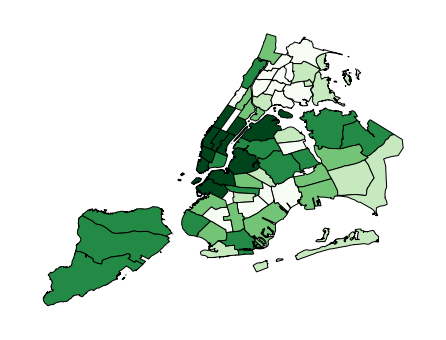

In [64]:
import mapclassify
import geoplot

# let's split up the gym counts by quantiles ranges
count = df_gym_cd['number_of_gyms']
scheme = mapclassify.Quantiles(count, k=5)

geoplot.choropleth(
    df_gym_cd, hue=count, scheme=scheme,
    cmap='Greens', figsize=(12, 6)
);

In [65]:
scheme

Quantiles               

    Interval       Count
------------------------
[  2.00,   8.00] |    14
(  8.00,  17.40] |    10
( 17.40,  25.80] |    11
( 25.80,  47.00] |    13
( 47.00, 165.00] |    11

Create a column in the dataset to include the quantile ranges for creating heatmap in web app later.

In [67]:
# let's add column for the quantile range for each cd
def gym_cnt_quantile(x):
    if x <= 8:
        return '[2.00, 8.00]'
    if x > 8 and x <= 17.40:
        return '(8.00, 17.40]'
    if x > 17.40 and x <= 25.80:
        return '(17.40, 25.80]'
    if x > 25.80 and x <= 47.00:
        return '(25.80, 47.00]'
    if x > 47.00 and x <= 165.00:
        return '(47.00, 165.00]'

In [69]:
df_gym_cd['gym_cnt_range'] = df_gym_cd['number_of_gyms'].apply(gym_cnt_quantile)
df_gym_cd['gym_cnt_range']

0     (47.00, 165.00]
1     (47.00, 165.00]
2      (25.80, 47.00]
3     (47.00, 165.00]
4     (47.00, 165.00]
5     (47.00, 165.00]
6     (47.00, 165.00]
7     (47.00, 165.00]
8        [2.00, 8.00]
9      (17.40, 25.80]
10     (17.40, 25.80]
11     (25.80, 47.00]
12      (8.00, 17.40]
13       [2.00, 8.00]
14       [2.00, 8.00]
15       [2.00, 8.00]
16       [2.00, 8.00]
17       [2.00, 8.00]
18       [2.00, 8.00]
19     (17.40, 25.80]
20       [2.00, 8.00]
21      (8.00, 17.40]
22      (8.00, 17.40]
23       [2.00, 8.00]
24    (47.00, 165.00]
25    (47.00, 165.00]
26     (17.40, 25.80]
27      (8.00, 17.40]
28       [2.00, 8.00]
29    (47.00, 165.00]
30     (17.40, 25.80]
31     (25.80, 47.00]
32      (8.00, 17.40]
33     (25.80, 47.00]
34     (17.40, 25.80]
35       [2.00, 8.00]
36      (8.00, 17.40]
37     (17.40, 25.80]
38     (25.80, 47.00]
39       [2.00, 8.00]
40       [2.00, 8.00]
41     (17.40, 25.80]
42    (47.00, 165.00]
43     (25.80, 47.00]
44      (8.00, 17.40]
45       [

In [70]:
df_gym_cd

,boro_cd,shape_area,shape_leng,GEO_ID,GEO_LABEL,GEO_DISPLAY_NAME,total_population_cd,obesity_cd,geometry,number_of_gyms,gym_cnt_range
0,101.0,4.268659e+07,73762.393219,101.0,Manhattan CD 001,Financial District,130217.345712,24,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",73,"(47.00, 165.00]"
1,102.0,3.768921e+07,34130.595861,102.0,Manhattan CD 002,Greenwich Village and Soho,101000.735022,26,"POLYGON ((-73.99684 40.73736, -73.99362 40.736...",77,"(47.00, 165.00]"
2,103.0,4.687970e+07,30468.340600,103.0,Manhattan CD 003,Lower East Side and Chinatown,103831.154791,32,"POLYGON ((-73.98878 40.73397, -73.98718 40.733...",47,"(25.80, 47.00]"
3,104.0,4.931179e+07,67623.946684,104.0,Manhattan CD 004,Clinton and Chelsea,126139.483095,24,"POLYGON ((-73.99394 40.77318, -73.99370 40.773...",56,"(47.00, 165.00]"
4,105.0,4.379030e+07,35288.305200,105.0,Manhattan CD 005,Midtown,193083.299602,21,"POLYGON ((-73.97301 40.76428, -73.97141 40.763...",165,"(47.00, 165.00]"
5,106.0,3.872909e+07,42705.937484,106.0,Manhattan CD 006,Stuyvesant Town and Turtle Bay,193731.204933,15,"MULTIPOLYGON (((-73.96128 40.73016, -73.96128 ...",57,"(47.00, 165.00]"
6,107.0,5.315282e+07,39863.701384,107.0,Manhattan CD 007,Upper West Side,103174.978364,28,"POLYGON ((-73.95965 40.80116, -73.95848 40.800...",94,"(47.00, 165.00]"
7,108.0,5.516880e+07,53561.096900,108.0,Manhattan CD 008,Upper East Side,164500.003324,28,"MULTIPOLYGON (((-73.94180 40.76905, -73.94257 ...",101,"(47.00, 165.00]"
8,109.0,4.189218e+07,34959.184938,109.0,Manhattan CD 009,Morningside Heights and Hamilton Heights,166931.655361,26,"POLYGON ((-73.94014 40.83037, -73.93963 40.830...",6,"[2.00, 8.00]"
9,110.0,3.908463e+07,35825.290700,110.0,Manhattan CD 010,Central Harlem,88571.946738,41,"POLYGON ((-73.93445 40.83598, -73.93456 40.835...",24,"(17.40, 25.80]"


Export as a geojson for heatmap viz in web app.


In [72]:
df_gym_cd.to_file("datasets/gyms_cd.geojson", driver='GeoJSON')
